In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/M1_S2/ML/projet
import numpy as np
from mltools import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/M1_S2/ML/projet


In [2]:
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
         xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//2)
         xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//2)
         data=np.vstack((xpos,xneg))
         y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y.reshape(-1, 1)

In [3]:
class Loss(object):
    def forward(self, y, yhat):
        pass

    def backward(self, y, yhat):
        pass

class MSELoss(Loss):
    def forward(self, y, yhat):
        """ Calculer le coût en fonction des 2 entrées
        """
        return np.linalg.norm(y-yhat, axis=1)**2

    def backward(self, y, yhat):
        """ Calculer le gradient du cout par rapport yhat
        """
        return -2*(y-yhat)


class Module(object):
    def __init__(self):
        self._parameters = None
        self._gradient = None

    def zero_grad(self):
        ## Annule gradient
        pass

    def forward(self, X):
        ## Calcule la passe forward
        pass

    def update_parameters(self, gradient_step=1e-3):
        ## Calcule la mise a jour des parametres selon le gradient calcule et le pas de gradient_step
        self._parameters -= gradient_step*self._gradient

    def backward_update_gradient(self, input, delta):
        ## Met a jour la valeur du gradient
        pass

    def backward_delta(self, input, delta):
        ## Calcul la derivee de l'erreur
        pass

class Linear(Module):
    def __init__(self, input, output):
        """ Une couche linéaire dans le réseau de neurones

        Args:
            input (int): le nombre d'entrées
            output (int): le nombre de sorties
        """
        super().__init__()
        self._parameters = np.random.randn(output, input) # W
        #self._parameters = np.random.randn(input, output)
        #print(self._parameters.shape)
        self._gradient = np.zeros_like(self._parameters)

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        self._gradient = np.zeros_like(self._parameters)
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return np.dot(X,self._parameters.T) # <x,w>
        #return np.dot(X,self._parameters)
    
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        self._parameters -= gradient_step*self._gradient
        self.zero_grad()
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        #print("BW_grad_Lin",delta.T.shape, input.shape)
        gradient = delta.T@input
        #print(gradient.shape)
        #print(self._gradient.shape)
        #gradient = np.dot(input.T, delta)
        # print(gradient.shape)
        # print(self._gradient.shape)
        self._gradient += gradient
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        return np.dot(delta, self._parameters)
        #return np.dot(delta, self._parameters.T)
    

class TanH(Module): # (e(z)-e(-z)) / (e(z)+e(-z))
    def __init__(self):
        """ Une couche tanH dans le réseau de neurones
        """
        super().__init__()
        

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        pass
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return  np.tanh(X)
    
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        pass
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        pass
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        dzda = (2/(np.exp(input)-np.exp(-input)))**2
        #print(input.shape)
        #print(dzda.shape)
        return delta*dzda     
    
class Sigmoide(Module): # 1 / (1+e(-z))
    def __init__(self):
        """ Une couche tanH dans le réseau de neurones
        """
        super().__init__()
        

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        pass
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return  1/(1+np.exp(-X))
    
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        pass
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        pass
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        dzda = np.exp(-input)/(1+np.exp(-input))**2
        #print(input.shape)
        #print(dzda.shape)
        return delta*dzda     


# Linéaire

## Une couche

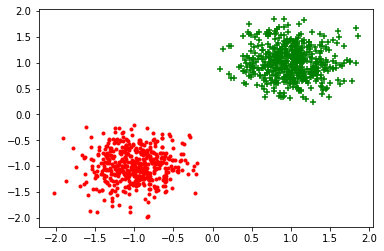

In [4]:
X, Y = gen_arti()
plot_data(X,Y)

[[-1.7313306  -0.60898453]]
Acc: 0.0


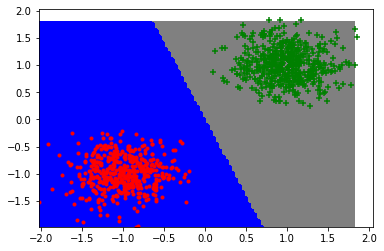

In [5]:
M = Linear(X.shape[1], 1)
print(M._parameters)
y_pred = M.forward(X)
y_hat = np.sign(y_pred)
plot_frontiere(X,lambda x : np.sign(M.forward(x)),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

[[5.21082238 6.14447127]]
Acc: 1.0


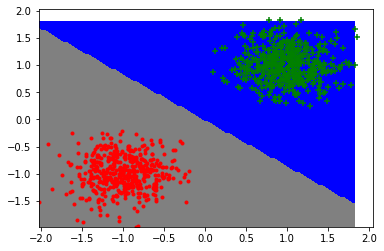

In [6]:
Loss = MSELoss()
L = Loss.forward(Y,y_hat)
delta = Loss.backward(Y,y_pred)
M.backward_update_gradient(X,delta)
M.update_parameters()
print(M._parameters)
y_pred = M.forward(X)
y_hat = np.sign(y_pred)
plot_frontiere(X,lambda x : np.sign(M.forward(x)),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

## Deux couches

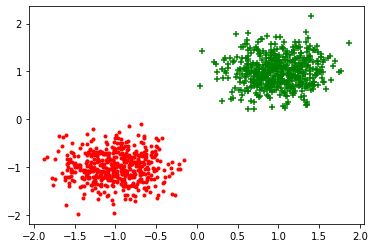

In [7]:
X, Y = gen_arti()
plot_data(X,Y)

Acc: 0.0


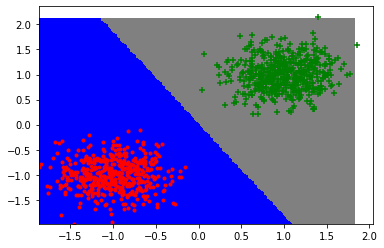

In [8]:
# Couche 1: 2 neurones, couche 2: 1 neurone
M1 = Linear(X.shape[1], 2)
M2 = Linear(M1._parameters.shape[0], 1)
z_1 = M1.forward(X)
z_2 = M2.forward(z_1)
y_hat = np.sign(z_2)


#print(z_1.shape)
#print(z_2.shape)
#print(M2._parameters)
#print(M2._parameters.shape)
plot_frontiere(X,lambda x : np.sign(M2.forward(M1.forward(x))),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 1.0


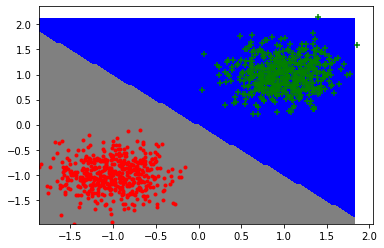

In [14]:
#Back propagation
Loss = MSELoss()
delta2 = Loss.backward(Y,z_2)
#M2
M2.backward_update_gradient(X,delta2)
delta1= M2.backward_delta(z_1, delta2)
M2.update_parameters()

#M1
M1.backward_update_gradient(X,delta1)
M1.update_parameters()

#Foward
z_1 = M1.forward(X)
z_2 = M2.forward(z_1)
y_hat = np.sign(z_2)
plot_frontiere(X,lambda x : np.sign(M2.forward(M1.forward(x))),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

# Second: Non-linéaire

Lin-Tanh-Lin-Sig

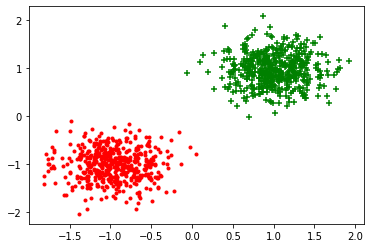

In [15]:
X, Y = gen_arti()
#Y = np.where(Y==-1,0,1)
plot_data(X,Y)

Acc: 0.0


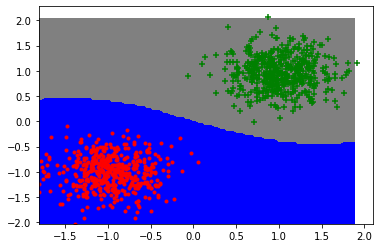

In [16]:
#ini
MLin1 = Linear(X.shape[1],2)
MtanH = TanH()
MLin2 = M2 = Linear(M1._parameters.shape[0], 1) #w_h1(out,in)
MSig = Sigmoide()
#forward
z_1 = MLin1.forward(X)
z_1_tan = MtanH.forward(z_1)
z_2 = MLin2.forward(z_1_tan)
z_2_sig = MSig.forward(z_2)
#decision
y_pred = np.where(z_2_sig>0.5,1,-1)

def f_sig(X):
  A = MSig.forward(MLin2.forward(MtanH.forward(MLin1.forward(X))))
  return np.where(A>0.5,1,-1)

#plot
plot_frontiere(X,f_sig,step=100)
plot_data(X,Y)
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 1.0


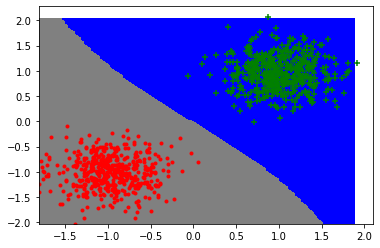

In [17]:

#Back propagation
Loss = MSELoss()
delta_sortie = Loss.backward(Y,z_2_sig)
#Sig
delta_sig = MSig.backward_delta(z_2,delta_sortie)
#Lineaire 2
M2.backward_update_gradient(z_1_tan,delta_sig)
delta_2 = M2.backward_delta(z_1_tan, delta_sig)
M2.update_parameters(gradient_step=0.1)
#TanH
delta_tanH = MtanH.backward_delta(z_1,delta_2)
#Lineaire 2
M1.backward_update_gradient(X,delta_tanH)
M1.update_parameters(gradient_step=0.1)


#forward
z_1 = MLin1.forward(X)
z_1_tan = MtanH.forward(z_1)
z_2 = MLin2.forward(z_1_tan)
z_2_sig = MSig.forward(z_2)
#decision
y_pred = np.where(z_2_sig>0.5,1,-1)


#plot
plot_frontiere(X,f_sig,step=100)
plot_data(X,Y)
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))